# Acne Detection
### Approach 1 - Using Resnet18
### Dataset - Acne04 (source - kaggle)

In [1]:
# Import necessary libraries
import io
import torch
import PIL
from fastai.vision.all import *  
from fastai.vision.core import PILImage
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path = "./data/" 
size = 224 
bs = 64  

In [3]:
data = ImageDataLoaders.from_folder(path, valid_pct=0.2, size=size, bs=bs)
learner = cnn_learner(data, models.resnet18)



C:\Users\user\anaconda3\envs\pytorch_env\lib\site-packages\fastai\vision\learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


In [4]:
try:
    learner.load('best_resnet', strict=False) 
except Exception as e:
    print(f"Error loading model: {e}")

labels = ['level_0', 'level_1', 'level_2', 'normal']
acne_scores = {
    'normal': 0,
    'level_0': 25,
    'level_1': 50,
    'level_2': 100
}



C:\Users\user\anaconda3\envs\pytorch_env\lib\site-packages\fastai\learner.py:60: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


In [5]:
def predict(image_path):
    """Predict acne level from an image path and display the image."""
    image = PIL.Image.open(image_path).convert("RGB")

    img_fastai = PILImage.create(image)

    output = learner.predict(img_fastai)

    classIdx = np.argmax(output[2])
    
    predicted_label = labels[classIdx]
    acne_level_score = acne_scores[predicted_label]
    
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off') 
    plt.title(f"This is {predicted_label} skin\nConfidence: {output[2][classIdx].item():.2f}\nAcne Score: {acne_level_score}/100")
    plt.show()



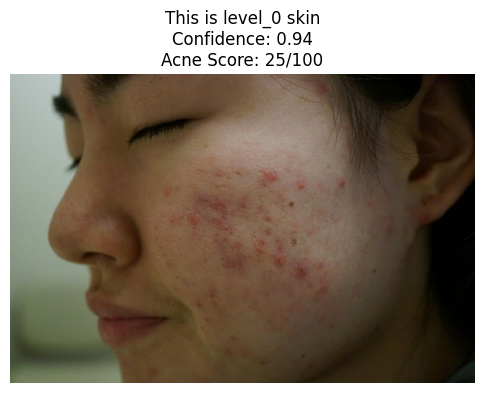

None


In [6]:
image_path = "./acne_sample.jpg"  
result = predict(image_path)

print(result) 

### Approach 2 - Resnet50
### Dataset - Acne04

In [22]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.optim as optim



In [23]:
DATASET_PATH = "./data/"  
IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 5
LEARNING_RATE = 0.001
VAL_SPLIT = 0.2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [24]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(root_dir))  

        for label, subdir in enumerate(self.classes):
            subdir_path = os.path.join(root_dir, subdir)
            if os.path.isdir(subdir_path):
                for file in os.listdir(subdir_path):
                    if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                        self.image_paths.append(os.path.join(subdir_path, file))
                        self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, label

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

full_dataset = CustomImageDataset(DATASET_PATH, transform=transform)

val_size = int(len(full_dataset) * VAL_SPLIT)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [4]:
num_classes = len(full_dataset.classes)
print(f"Classes: {full_dataset.classes}")

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes) 
model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)


Classes: ['level_0', 'level_1', 'level_2', 'models', 'normal']


C:\Users\user\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\envs\pytorch_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
def train_and_validate(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0

        for images, labels in train_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()

        train_accuracy = train_correct / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

        model.eval()
        val_loss = 0.0
        val_correct = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()

        val_accuracy = val_correct / len(val_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

In [6]:
train_and_validate(model, train_loader, val_loader, criterion, optimizer, EPOCHS)

Epoch 1/5, Train Loss: 84.3883, Train Accuracy: 0.5081
Epoch 1/5, Val Loss: 18.4515, Val Accuracy: 0.5922
Epoch 2/5, Train Loss: 67.0528, Train Accuracy: 0.5960
Epoch 2/5, Val Loss: 16.7523, Val Accuracy: 0.5405
Epoch 3/5, Train Loss: 59.3094, Train Accuracy: 0.6677
Epoch 3/5, Val Loss: 13.4620, Val Accuracy: 0.7184
Epoch 4/5, Train Loss: 54.8605, Train Accuracy: 0.6919
Epoch 4/5, Val Loss: 11.9947, Val Accuracy: 0.7184
Epoch 5/5, Train Loss: 50.8183, Train Accuracy: 0.7097
Epoch 5/5, Val Loss: 9.3058, Val Accuracy: 0.8155


In [7]:
torch.save(model.state_dict(), "resnet50_custom_dataset.pth")
print("Model training complete and saved.")

Model training complete and saved.


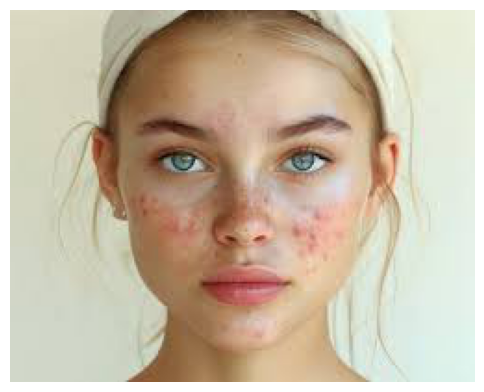

Predicted Acne Severity: Moderate


In [13]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

MODEL_PATH = "resnet50_custom_dataset.pth"

TEST_IMAGE_PATH = "acne_sample.jpg"

model = models.resnet50(pretrained=False) 
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(MODEL_PATH))
model = model.to(DEVICE)
model.eval()

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

image = Image.open(TEST_IMAGE_PATH).convert("RGB")
input_tensor = test_transform(image).unsqueeze(0).to(DEVICE)  

with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted_class = torch.max(outputs, 1)
    
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off') 
plt.show()

predicted_label = full_dataset.classes[predicted_class.item()]
if predicted_label == "level_0":
    predict_label = "Low"
elif predicted_label == "level_1":
    predict_label = "Moderate"
elif predicted_label == "level_2":
    predict_label = "Severe"
print(f"Predicted Acne Severity: {predict_label}")


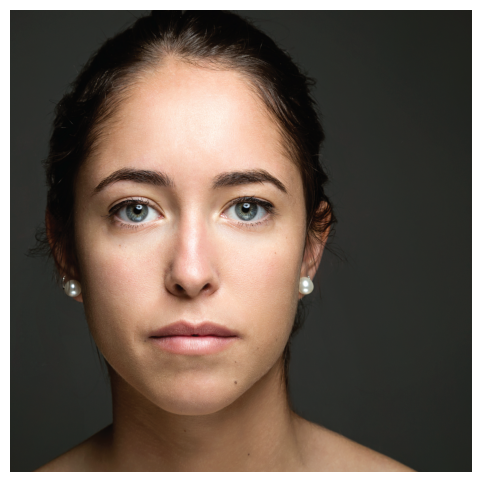

Predicted Acne Severity: Low


In [14]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

MODEL_PATH = "resnet50_custom_dataset.pth"

TEST_IMAGE_PATH = "img.png"

model = models.resnet50(pretrained=False) 
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.load_state_dict(torch.load(MODEL_PATH))
model = model.to(DEVICE)
model.eval()

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

image = Image.open(TEST_IMAGE_PATH).convert("RGB")
input_tensor = test_transform(image).unsqueeze(0).to(DEVICE)  

with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted_class = torch.max(outputs, 1)
    
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis('off') 
plt.show()

predicted_label = full_dataset.classes[predicted_class.item()]
if predicted_label == "level_0":
    predict_label = "Low"
elif predicted_label == "level_1":
    predict_label = "Moderate"
elif predicted_label == "level_2":
    predict_label = "Severe"
print(f"Predicted Acne Severity: {predict_label}")


### Acne density

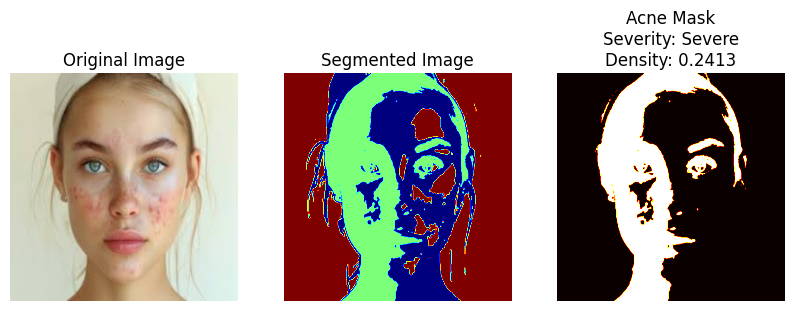

Acne Density: 0.2413
Severity: Severe


In [18]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def preprocess_image(image_path, target_size=(512, 512)):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, target_size)
    return image

def cluster_acne_regions(image, n_clusters=3):
    pixel_values = image.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)
    
    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(pixel_values)
    centers = kmeans.cluster_centers_

    segmented_image = labels.reshape(image.shape[:2])
    return segmented_image, centers

def calculate_acne_density(image_path):
    image = preprocess_image(image_path)
    segmented_image, centers = cluster_acne_regions(image, n_clusters=3)

    acne_cluster = np.argmin([np.mean(center) for center in centers])  
    acne_mask = (segmented_image == acne_cluster).astype(np.uint8)
    
    acne_pixels = np.sum(acne_mask)
    total_pixels = acne_mask.size
    acne_density = acne_pixels / total_pixels
    
    if acne_density < 0.01:
        severity = 'Low'
    elif 0.01 <= acne_density < 0.05:
        severity = 'Moderate'
    else:
        severity = 'Severe'
    
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(segmented_image, cmap='jet')
    plt.title("Segmented Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(acne_mask, cmap='hot')
    plt.title(f"Acne Mask\nSeverity: {severity}\nDensity: {acne_density:.4f}")
    plt.axis('off')
    plt.show()
    
    return severity, acne_density

image_path = 'acne_sample.jpg' 
severity, acne_density = calculate_acne_density(image_path)
print(f'Acne Density: {acne_density:.4f}')
print(f'Severity: {severity}')
